<a href="https://colab.research.google.com/github/MoayadBatwa/NLP-SentimentAnalysis/blob/main/SentimentAnalysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [7]:
pip install pandas nltk matplotlib seaborn

## Load and Inspect Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (run this once)
nltk.download('stopwords')

# 1. Load the Dataset
# Replace 'Tweets.csv' with the path to your actual downloaded file
# If you don't have the file yet, this simulates what the dataframe looks like:
try:
    df = pd.read_csv('Tweets.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("File not found. creating sample data for demonstration...")
    data = {
        'airline_sentiment': ['positive', 'negative', 'neutral', 'negative', 'positive'],
        'text': [
            "@VirginAmerica Plus you've added commercials to the experience... tacky.",
            "@United really missed a prime opportunity for Men Without Hats parody",
            "@SouthwestAir I didn't get the flight information?",
            "@USAirways it's really bad customer service.",
            "@JetBlue thanks for the great flight!"
        ]
    }
    df = pd.DataFrame(data)

# 2. Initial Inspection (Exploratory Data Analysis - EDA)
print(f"Dataset Shape: {df.shape}")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows where 'text' or 'airline_sentiment' is missing (Data Quality) [cite: 20]
df.dropna(subset=['text', 'airline_sentiment'], inplace=True)

Dataset loaded successfully!
Dataset Shape: (14640, 15)
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin               

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [9]:
# Load stop words (e.g., "the", "is", "in")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Convert to lowercase to maintain consistency
    text = text.lower()

    # 2. Remove Twitter handles (e.g., @United) using Regex
    text = re.sub(r'@\w+', '', text)

    # 3. Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Remove Stopwords (Optional but recommended for sentiment)
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words]

    return " ".join(filtered_words)

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Show the difference
print("\n--- Before vs After Cleaning ---")
print(df[['text', 'clean_text']].head())


--- Before vs After Cleaning ---
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                               said  
1      plus youve added commercials experience tacky  
2       didnt today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing  


## Visualizing the Target (EDA)

/tmp/ipython-input-943990609.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='viridis')


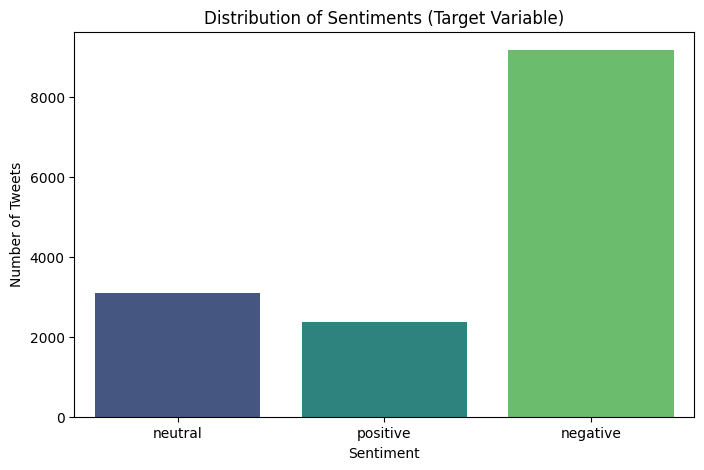

In [10]:
# Visualize the distribution of sentiments
plt.figure(figsize=(8, 5))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments (Target Variable)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

## Feature Extraction and Model Training

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Feature Extraction (TF-IDF) ---
# Convert the 'clean_text' column into numerical vectors
# max_features=5000 keeps only the top 5,000 most frequent words to reduce noise
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['airline_sentiment']

print(f"Feature Matrix Shape: {X.shape}")

# --- 2. Train-Test Split ---
# Split data: 80% for training the model, 20% for testing it
# random_state ensures you get the same split every time you run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# --- 3. Model Training ---
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)  # increased max_iter for convergence
model.fit(X_train, y_train)

print("\nModel training complete!")

Feature Matrix Shape: (14640, 5000)
Training samples: 11712
Testing samples: 2928

Model training complete!


## Model Evaluation

Accuracy Score: 0.80

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.94      0.88      1889
     neutral       0.67      0.48      0.56       580
    positive       0.83      0.61      0.70       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928



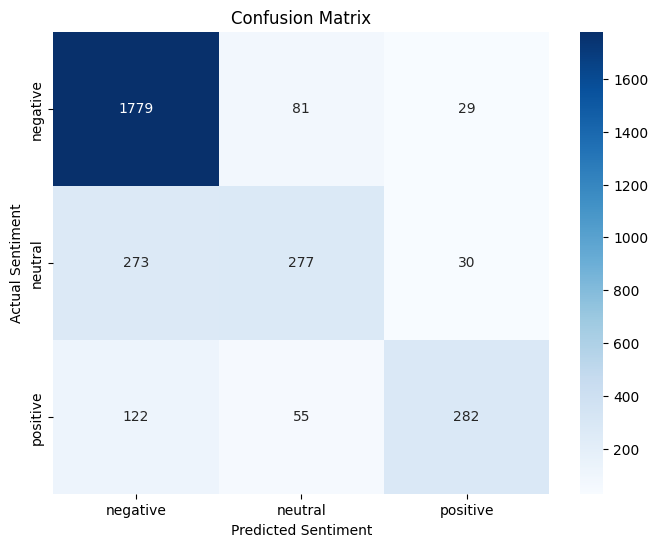

In [12]:
# --- 1. Make Predictions ---
y_pred = model.predict(X_test)

# --- 2. Calculate Metrics ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 3. Visualizing Results (Confusion Matrix) ---
# This satisfies the requirement for "visuals like charts, confusion matrices" [cite: 44]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.title('Confusion Matrix')
plt.show()